In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set()
# sns.set_style('whitegrid')

In [2]:
def load_evolution_results(seed=123, database=''):
    ev_results = pd.read_csv(os.path.join('results', 'seed_' + str(seed),
                                          'parent_child_' + database),
                             names=['parent', 'child'])
    ev_results['index'] = ev_results.index
    ev_results = pd.melt(ev_results, id_vars=['index'])
    initial_population_scores = pd.read_csv(os.path.join('results',
                                                         'seed_' + str(seed),
                                                         'initial_population_' + database),
                                            header=None,
                                            names=['scores'])
    ev_time = open(os.path.join('results',
                                'seed_' + str(seed),
                                'time_' + database), 'r').read()
    return ev_results, ev_time, initial_population_scores

In [3]:
def load_RL_results(seed=123, database=''):
    indexes = []
    val_scores = []
    store = False
    times = []
    with open(os.path.join('results', 'seed_' + str(seed), 'results_RL_' + database), 'r') as fp:
        for index, line in enumerate(fp):
            if 'took' in line:
#                 print(line.split())
                times.append(float(line.split()[-1]))
            if 'val_score' in line and store:
                val_scores.append(float(line.split(',')[0].split(':')[1]))
            if 'training controller' in line:
                indexes.append(index)
                if 'over' in line:
                    store = False
                else:
                    store = True
    df = pd.DataFrame()
#     print('val_scores len: ', len(val_scores))
    df['index'] = np.arange(len(val_scores))
    df['val_scores'] = np.array(val_scores)
    return df, pd.DataFrame(np.array(times), columns=['times'])

In [4]:
def draw_lineplots(database, ev_results, rl_results, all_seeds=False):
    # parent_child_acc
    fig, ax = plt.subplots(1, 2, figsize=(18.75, 6), sharey=False)

    sns.lineplot(x='index', y='value', hue='variable', data=ev_results, ax=ax[0])
    sns.lineplot(x='index', y='val_scores', data=rl_results, ax=ax[1])
    ax[0].set_title('Evolution')
    ax[1].set_title('Reinforcement Learning')
    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')
    ax[0].set_ylabel('Validation Score')
    ax[1].set_ylabel('Validation Score')
    if not all_seeds:
        plt.savefig(os.path.join('results', 'plots', 'validation_score_per_epoch_' + database + '.pdf'))
    else:
        plt.savefig(os.path.join('results', 'plots', 'validation_score_per_epoch_' + database + '_all_seeds.pdf'))

In [5]:
def draw_boxplots(database, ev_results, rl_results, all_seeds=False):
    fig, ax = plt.subplots(1, 2, figsize=(18.75, 6), sharey=False)
    sns.boxplot(x='variable', y='value', data=ev_results, ax=ax[0])
    sns.boxplot(y='val_scores', data=rl_results, ax=ax[1])

    ax[0].set_title('Evolution')
    ax[1].set_title('Reinforcement Learning')

    ax[0].set_xlabel('')
    ax[0].set_ylabel('Validation Score')
    ax[1].set_ylabel('Validation Score')
    if not all_seeds:
        plt.savefig(os.path.join('results', 'plots', 'validation_score_boxplot_' + database + '.pdf'))
    else:
        plt.savefig(os.path.join('results', 'plots', 'validation_score_boxplot_' + database + '_all_seeds.pdf'))

# Citeseer

In [6]:
ev_results, ev_times, initial_pop_scores = load_evolution_results(seed=123, database='citeseer')
rl_results, rl_times = load_RL_results(seed=123, database='citeseer')

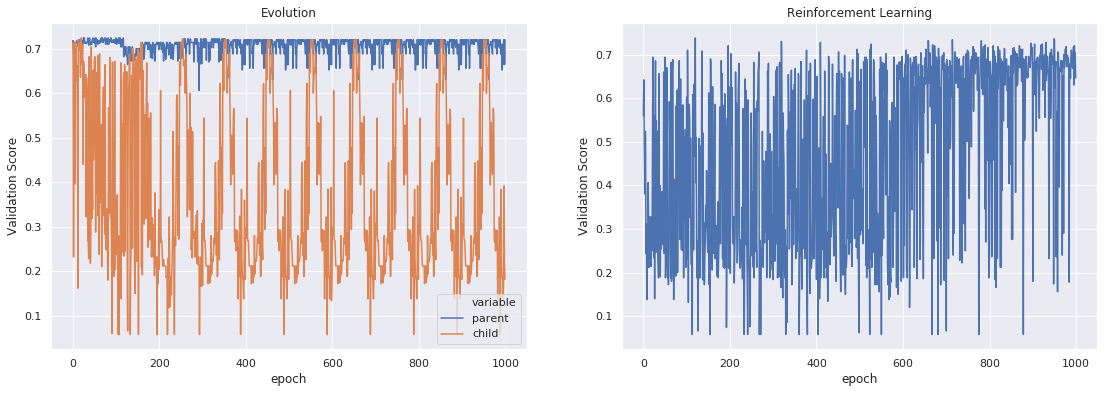

In [7]:
draw_lineplots('citeseer', ev_results, rl_results)

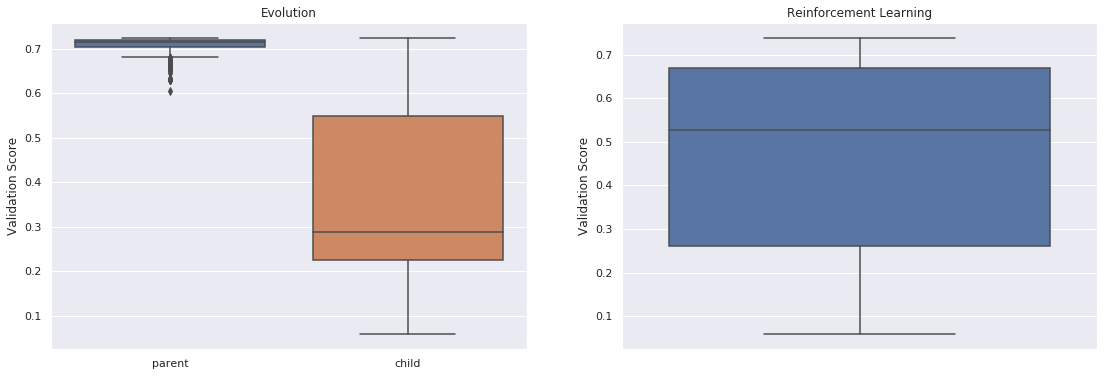

In [8]:
draw_boxplots('citeseer', ev_results, rl_results)

### Time analysis

In [9]:
# time analysis
# rl_times = np.array(rl_times)
print("Total RL time: ", np.sum(rl_times.values), ' avg. epoch time: ', np.mean(rl_times.values), ' stddev: ', np.std(rl_times.values))
# print("Total RL time: ", rl_times.sum(), ' avg. epoch time: ', rl_times.mean().value, ' stddev: ', rl_times.std().value)
# print('RL Time:')
# print(rl_times.describe())
print("Evolution time:")
print(ev_times)

Total RL time:  22882.98808479309  avg. epoch time:  2288.298808479309  stddev:  304.67587585978197
Evolution time:
Time elapsed initializing population: 1261.6691863536835
Time spend on evolution: 10766.40284872055
Total elapsed time: 12028.072075128555



### Boxplot of the Initial population's fitness

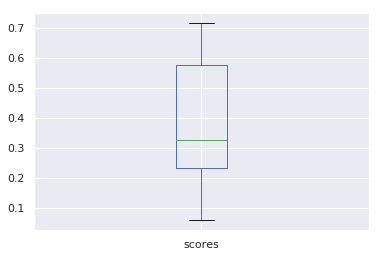

In [10]:
initial_pop_scores.plot.box()

# Cora

In [11]:
# Load Data
ev_results, ev_times, initial_pop_scores = load_evolution_results(seed=123, database='cora')
rl_results, rl_times = load_RL_results(seed=123, database='cora')

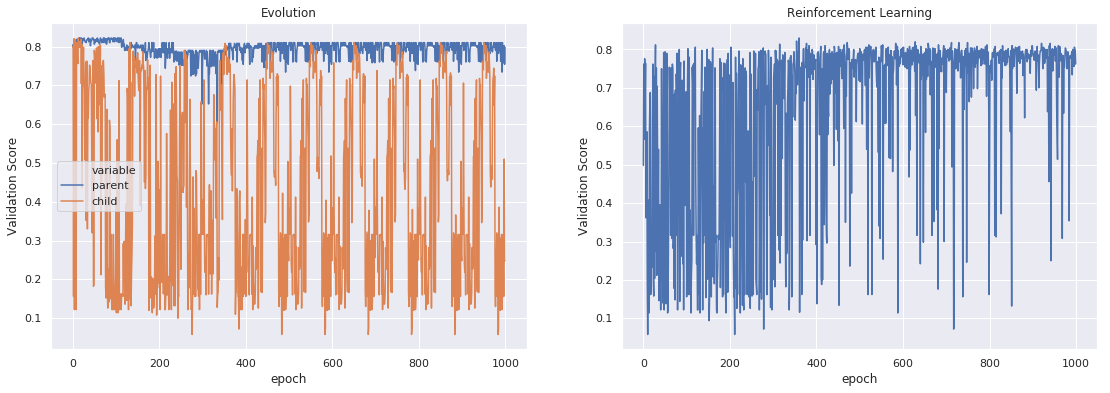

In [12]:
draw_lineplots('cora', ev_results, rl_results)

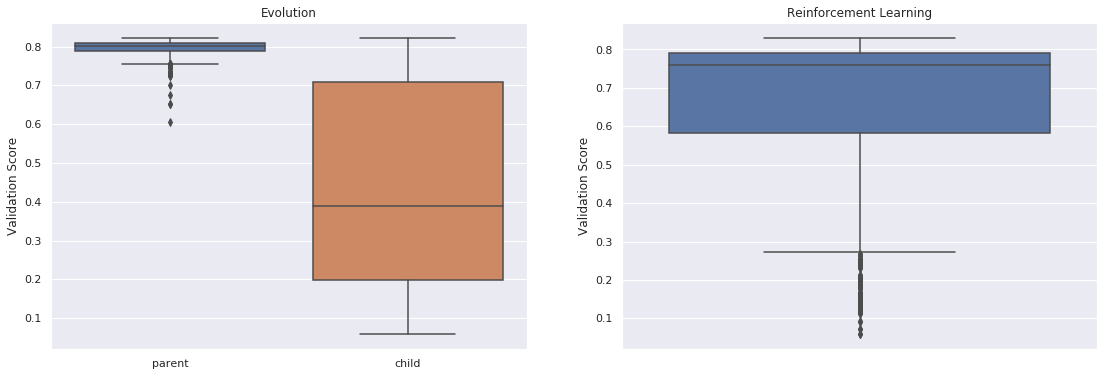

In [13]:
draw_boxplots('cora', ev_results, rl_results)

### Time analysis

In [14]:
# time analysis
rl_times = np.array(rl_times)
print("Total RL time: ", np.sum(rl_times),
      ' avg. epoch time: ', np.mean(rl_times),
      ' stddev: ', np.std(rl_times))
print("Evolution time:")
print(ev_times)

Total RL time:  22526.24834370613  avg. epoch time:  2252.624834370613  stddev:  267.90124688127617
Evolution time:
Time elapsed initializing population: 1226.007264137268
Time spend on evolution: 10871.277530431747
Total elapsed time: 12097.284837007523



### Boxplot of the Initial population's fitness

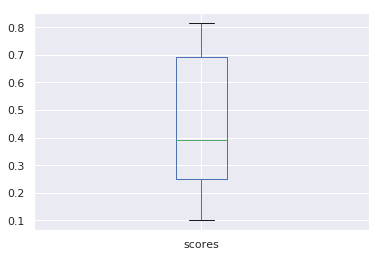

In [15]:
initial_pop_scores.plot.box()

# Pubmed

In [16]:
# Load Data
ev_results, ev_times, initial_pop_scores = load_evolution_results(seed=123, database='pubmed')
rl_results, rl_times = load_RL_results(seed=123, database='pubmed')

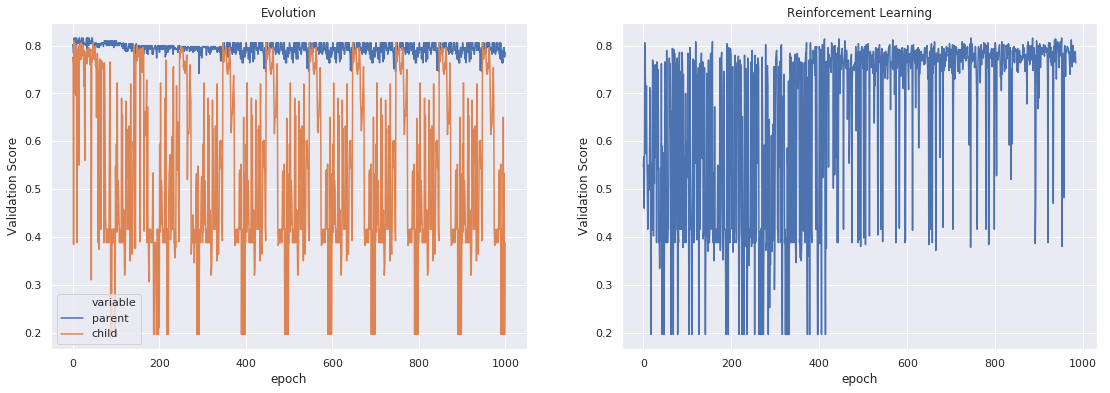

In [17]:
draw_lineplots('pubmed', ev_results, rl_results)

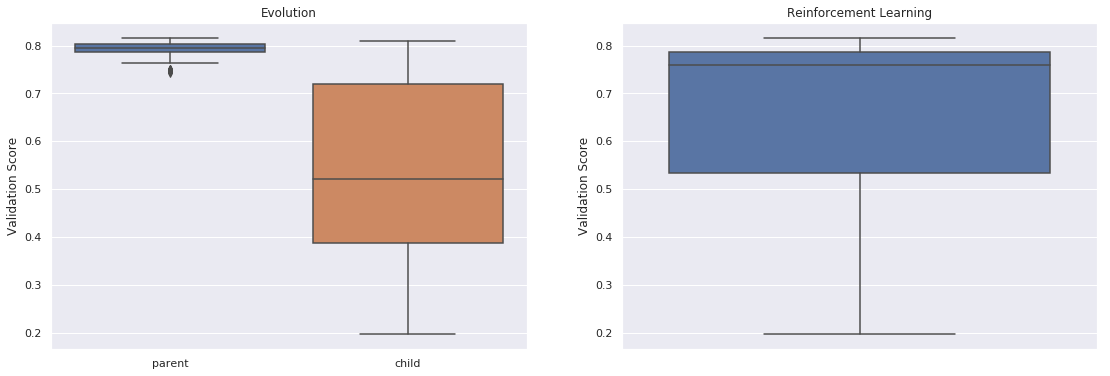

In [18]:
draw_boxplots('pubmed', ev_results, rl_results)

### Time analysis

In [19]:
# time analysis
rl_times = np.array(rl_times)
print("Total RL time: ", np.sum(rl_times),
      ' avg. epoch time: ', np.mean(rl_times),
      ' stddev: ', np.std(rl_times))
print("Evolution time:")
print(ev_times)

Total RL time:  35151.214247465134  avg. epoch time:  3515.121424746513  stddev:  1198.8915384753664
Evolution time:
Time elapsed initializing population: 2545.2917766571045
Time spend on evolution: 21997.837198019028
Total elapsed time: 24543.129021406174



### Boxplot of the Initial population's fitness

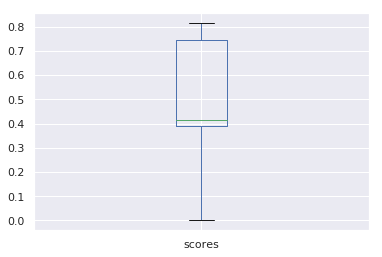

In [20]:
initial_pop_scores.plot.box()

## All seeds results (variance study)

In [21]:
def load_all_results(database=''):
    ev_results_all = pd.DataFrame(columns=['index', 'variable', 'value', 'seed'])
    initial_pop_all = pd.DataFrame(columns=['scores', 'seed'])
    rl_results_all = pd.DataFrame(columns=['index', 'val_scores', 'seed'])
    rl_times_all = pd.DataFrame(columns=['times', 'seed'])
    ev_times_all = {}
    for subdir in os.listdir('results'):
        if 'seed' in subdir:
            seed = subdir.split('_')[-1]
            # LOAD EVOLUTION RESULTS
            ev_results, ev_times, initial_pop_scores = \
                load_evolution_results(seed=seed, database=database)
            ev_results['seed'] = seed
            initial_pop_scores['seed'] = seed
            ev_results_all = pd.concat([ev_results_all, ev_results],
                                       axis=0,
                                       ignore_index=True, sort=False)
            initial_pop_all = pd.concat([initial_pop_all, initial_pop_scores],
                                        axis=0,
                                        ignore_index=True, sort=False)
            ev_times_all[seed] = ev_times
            # LOAD RL RESULTS
            rl_results, rl_times = load_RL_results(seed=seed, database=database)
            rl_results['seed'] = seed
            rl_results_all = pd.concat([rl_results_all, rl_results],
                                       axis=0,
                                       ignore_index=True, sort=False)
            rl_times['seed'] = seed
            rl_times_all = pd.concat([rl_times_all, rl_times],
                                     axis=0,
                                     ignore_index=True, sort=False)
    return ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all

In [22]:
def draw_initial_pop_boxplot(initial_pop_all):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.boxplot(x='seed', y='scores', data=initial_pop_all, ax=ax)
    ax.set_title('Initial Population Boxplot')
    ax.set_xlabel('Seed')
    ax.set_ylabel('Validation Score')

### Citeseer

In [23]:
ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all = load_all_results('citeseer')

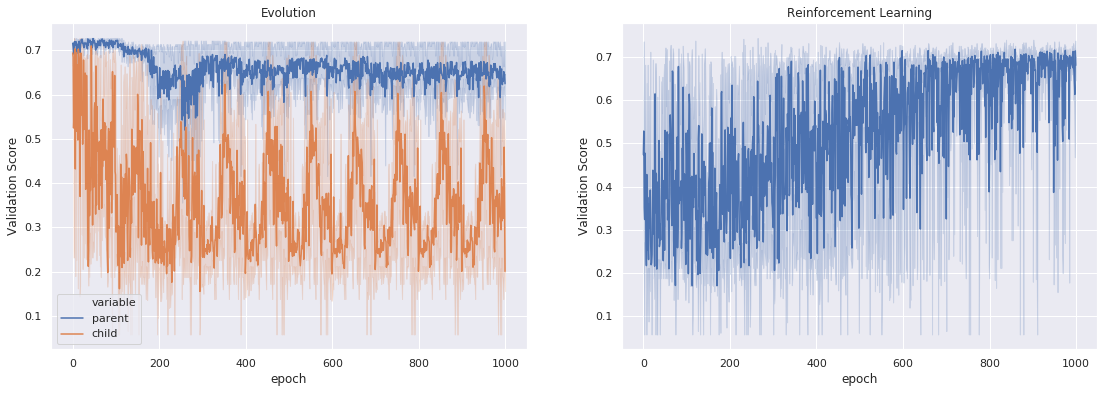

In [24]:
draw_lineplots('citeseer', ev_results_all, rl_results_all, all_seeds=True)

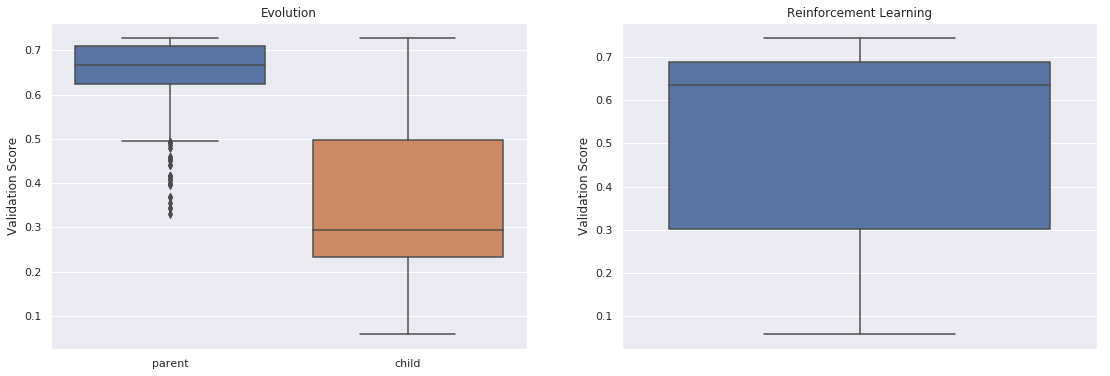

In [25]:
draw_boxplots('citeseer', ev_results_all, rl_results_all, all_seeds=True)

In [26]:
print('RL Time:')
print(rl_times_all.groupby('seed').sum(), '\n\n')
print('Evolution Time: ')
for seed, times in ev_times_all.items():
    print(seed, times)

RL Time:
             times
seed              
10    21962.605600
123   22882.988085
42    20631.567293 


Evolution Time: 
42 Time elapsed initializing population: 1309.977411031723
Time spend on evolution: 14444.781571388245
Total elapsed time: 15754.759024143219

10 Time elapsed initializing population: 1222.3303546905518
Time spend on evolution: 10814.082395553589
Total elapsed time: 12036.41279220581

123 Time elapsed initializing population: 1261.6691863536835
Time spend on evolution: 10766.40284872055
Total elapsed time: 12028.072075128555



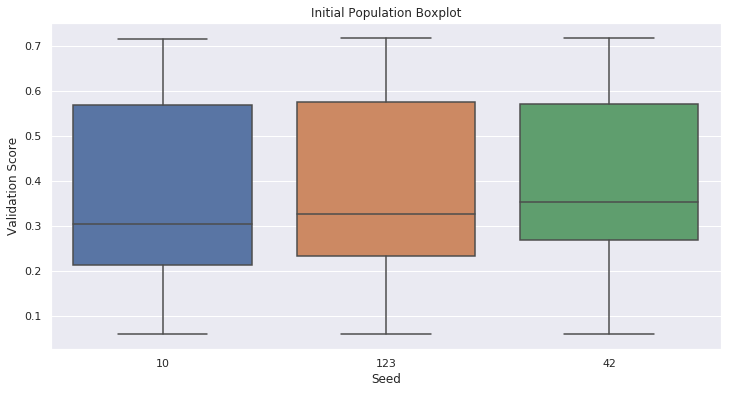

In [27]:
draw_initial_pop_boxplot(initial_pop_all)

### Cora

In [28]:
ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all = load_all_results('cora')

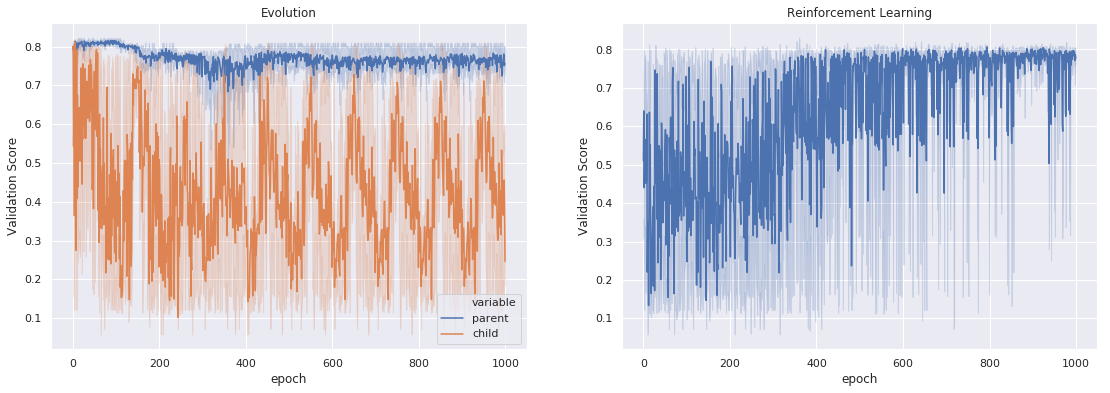

In [29]:
draw_lineplots('cora', ev_results_all, rl_results_all, all_seeds=True)

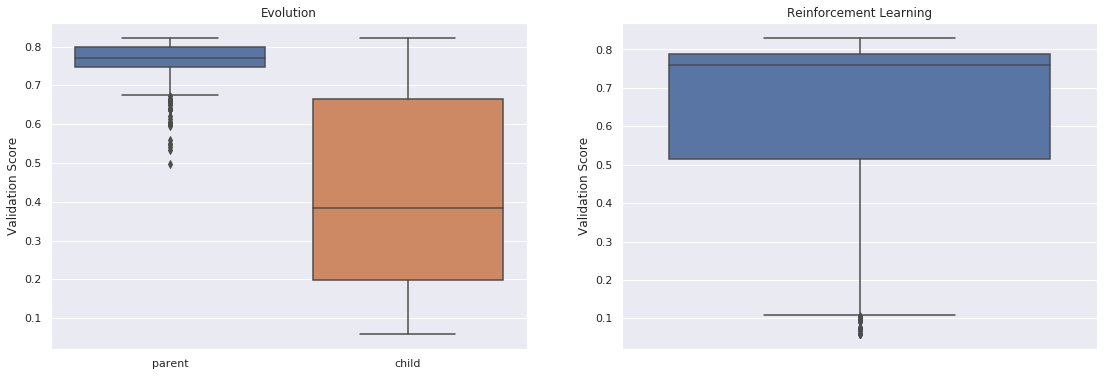

In [30]:
draw_boxplots('cora', ev_results_all, rl_results_all, all_seeds=True)

In [31]:
print('RL Time:')
print(rl_times_all.groupby('seed').sum(), '\n\n')
print('Evolution Time: ')
for seed, times in ev_times_all.items():
    print(seed, times)

RL Time:
             times
seed              
10    21895.281518
123   22526.248344
42    20631.187366 


Evolution Time: 
42 Time elapsed initializing population: 1318.7002747058868
Time spend on evolution: 14534.647342681885
Total elapsed time: 15853.347661495209

10 Time elapsed initializing population: 1219.940410375595
Time spend on evolution: 10717.802448749542
Total elapsed time: 11937.742901086807

123 Time elapsed initializing population: 1226.007264137268
Time spend on evolution: 10871.277530431747
Total elapsed time: 12097.284837007523



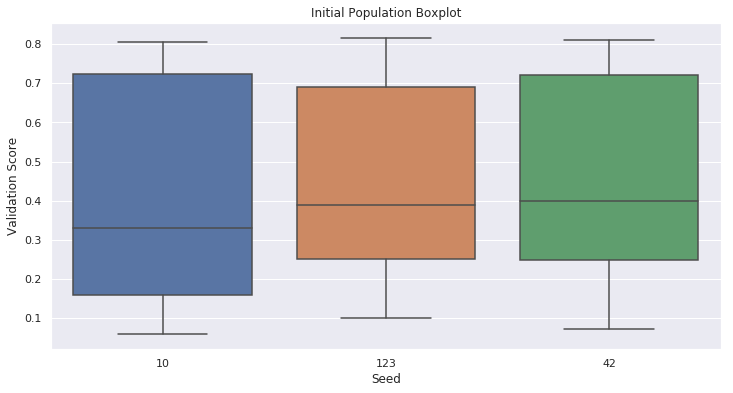

In [32]:
draw_initial_pop_boxplot(initial_pop_all)

### Pubmed

In [33]:
ev_results_all, initial_pop_all, ev_times_all, rl_results_all, rl_times_all = load_all_results('pubmed')

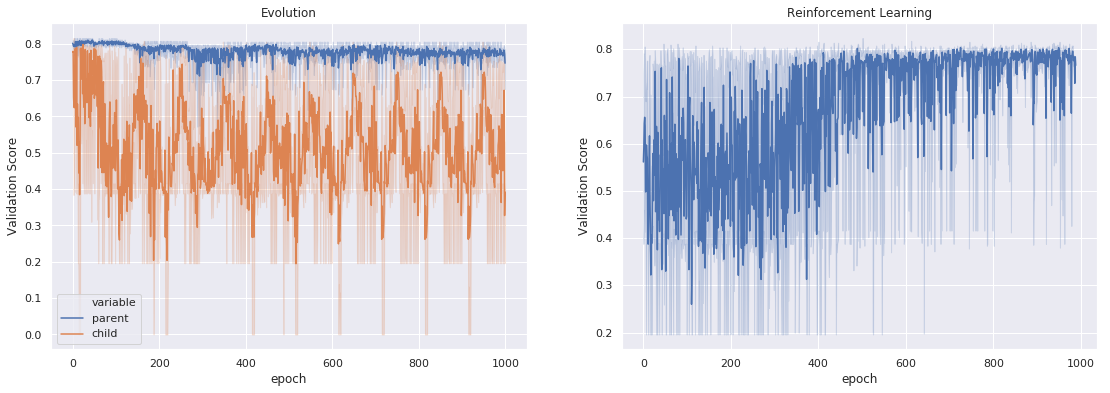

In [34]:
draw_lineplots('pubmed', ev_results_all, rl_results_all, all_seeds=True)

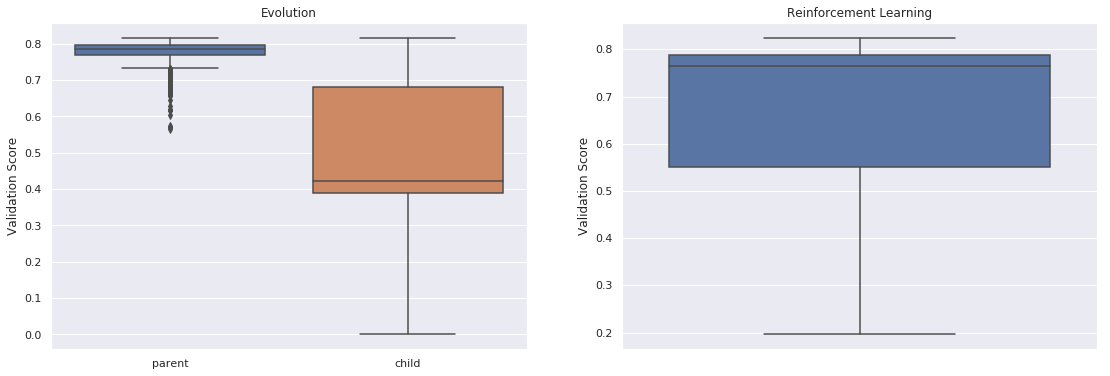

In [35]:
draw_boxplots('pubmed', ev_results_all, rl_results_all, all_seeds=True)

In [36]:
print('RL Time:')
print(rl_times_all.groupby('seed').sum(), '\n\n')
print('Evolution Time: ')
for seed, times in ev_times_all.items():
    print(seed, times)

RL Time:
             times
seed              
10    34414.328285
123   35151.214247
42    32928.685453 


Evolution Time: 
42 Time elapsed initializing population: 2473.2743577957153
Time spend on evolution: 26919.496432065964
Total elapsed time: 29392.770831108093

10 Time elapsed initializing population: 2586.6038370132446
Time spend on evolution: 22576.297870397568
Total elapsed time: 25162.901747226715

123 Time elapsed initializing population: 2545.2917766571045
Time spend on evolution: 21997.837198019028
Total elapsed time: 24543.129021406174



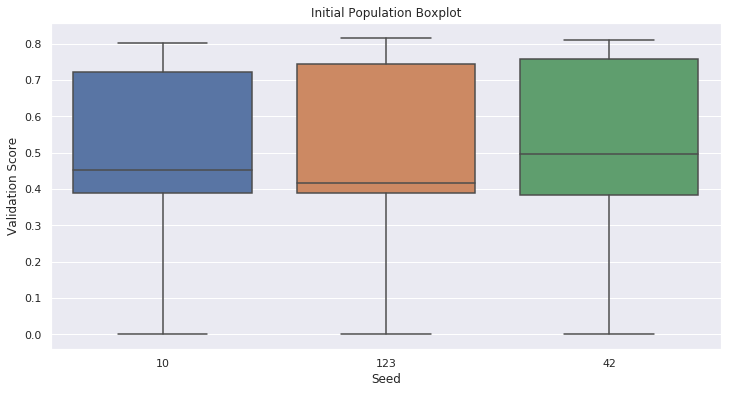

In [37]:
draw_initial_pop_boxplot(initial_pop_all)